## Using SQL with Google BigQuery
This notebook is an example of executing SQL commands using BigQuery to analyze data and pandas and matplotlib to visualize data. 


This notebook uses the Bay Area Bikeshare public dataset that is housed in GCP to show how I might answer some hypothetical business questions. The static tables used from the "san_francisco dataset" are:
- bikeshare_stations
- bikeshare_status
- bikeshare_trips

In [10]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

### What are the 5 Most Popular Commuter Trips?

In [1]:
%%bigquery popular_commuter_trips

SELECT start_station_name, end_station_name, COUNT(*) as total_trips
FROM `idyllic-analyst-264522.bikeshare_data.final_commuters` 
GROUP BY start_station_name, end_station_name 
ORDER BY total_trips DESC LIMIT 5

In [2]:
popular_commuter_trips

,start_station_name,end_station_name,total_trips
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5163
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5121
2,Embarcadero at Sansome,Steuart at Market,4760
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4752
4,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4682


The 5 most popular "commuter trips" are as follows (also displayed in the table above):
 -  2nd at Townsend to Harry Bridges Plaza (Ferry Building)
 -  Harry Bridges Plaza (Ferry Building) to 2nd at Townsend
 -  Embarcadero at SAnsome to Steuart at Market
 -  Embaracadero at Folsom to San Francisco Caltrain (Townsend at 4th)
 -  San Francisco Caltrain (Townsend at 4th) to Harry Bridges Plaza (Ferry Building)

I used the following criteria to define what a commuter is:  
 -  The start station name cannot be the same as the end station name - my theory behind this was that if someone is commuting to work they are starting at one station and ending at a different one.
 -  The day of the week for the trip must be a weekday - my theory behind that was that the majority of people who are regularly commuting to work would be working on weekdays.
 -  The start hour for the trip must be in the 7:00, 8:00, 9:00, 16:00, 17:00, or 18:00 hours - I looked at the data to try and determine what morning and evening hours people would typically be commuting and found that trips in the 7:00, 8:00, and 9:00 hours accounted for about 33% of the data and trips in the 16:00, 17:00, and 18:00 hours accounted for about 32% of the data, which both seemed reasonable to me.
 -  The trip duration must be greater than or equal to 5 minutes and less than or equal to 1 hour - I figured that commuter trips should not be too long and this subset accounts for 86% of the data, which seemed reasonable to me.

Based on this criteria, along with cleaning and filtering the data as described in this notebook in the "Temporary Tables" section, these 5 trips are the most popular among commuters because they have the most number of trips in this dataset. Please note that I consider a trip to be direction dependent, so even though the first two trips in the table above involve the same 2 stations, I consider this to be 2 different trips because for each trip a commuter would be traveling in a different direction.

### What are some promotions the company should offer?

#### Promote subscription options to commuters

In [41]:
%%bigquery commuter_customers

SELECT start_station_name, COUNT(trip_id) as total_trips
FROM `idyllic-analyst-264522.bikeshare_data.final_commuters` 
WHERE subscriber_type = 'Customer'
GROUP BY start_station_name
ORDER BY total_trips desc LIMIT 5

In [42]:
commuter_customers

,start_station_name,total_trips
0,Embarcadero at Sansome,2239
1,Harry Bridges Plaza (Ferry Building),1729
2,San Francisco Caltrain (Townsend at 4th),1469
3,Market at 4th,956
4,Steuart at Market,940


The table above shows the 5 stations people who are considered to be "commuters" and are customers (as opposed to subscribers) most frequently start their bike trips from. I recommend that Lyft Bay Wheels promote the subscriber options to commuters at these stations. Lyft Bay Wheels can promote the subscriber options by advertising in these stations and at businesses nearby these stations. 

#### Promote off-peak hours

In [43]:
%%bigquery trips_by_hour

SELECT start_hour, COUNT(trip_id) as total_trips
FROM `idyllic-analyst-264522.bikeshare_data.filtered_data` 
WHERE subscriber_type = 'Customer'
GROUP BY start_hour
ORDER BY start_hour ASC

Text(0.5, 0, 'Start Hour')

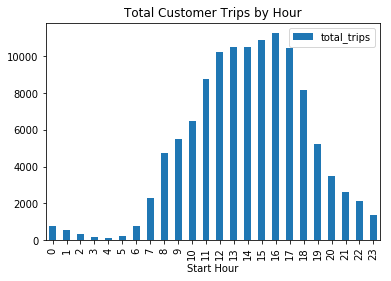

In [44]:
trips_by_hour.plot.bar(x = "start_hour", y = "total_trips", title = "Total Customer Trips by Hour")
plt.xlabel("Start Hour")

The graph above shows the total number of bike trips started every hour by customers (as opposed to subscribers). Lyft Bay Wheels should offer promotions during non-peak hours. Specifically, they should offer 50% off single rides between the hours of 8:00 PM and 8:00 AM. 

#### Offer an additional single ride option

In [45]:
%%bigquery single_rides

SELECT duration_minutes
FROM `idyllic-analyst-264522.bikeshare_data.filtered_data`
WHERE subscriber_type = 'Customer'

Text(0, 0.5, 'Frequency')

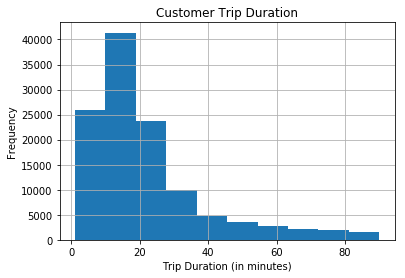

In [46]:
single_rides.hist(bins=10)
plt.title("Customer Trip Duration")
plt.xlabel("Trip Duration (in minutes)")
plt.ylabel("Frequency")

The histogram above shows that the majority of rides taken by customers (as opposed to subscribers) are actually under 20 minutes in duration. The current price for a single ride is 2 dollars for a ride that can last up to 30 minutes. I think it would be beneficial to offer an additional single ride promotion that costs 1 dollar for a single ride that can last up to 15 minutes.  

#### Modify the monthly/annual subscription options

In [49]:
%%bigquery subscription_rides

SELECT duration_minutes 
FROM `idyllic-analyst-264522.bikeshare_data.filtered_data`
WHERE subscriber_type = 'Subscriber'

Text(0, 0.5, 'Frequency')

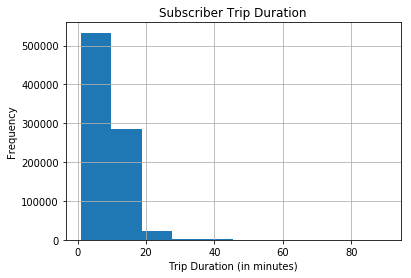

In [50]:
subscription_rides.hist(bins=10)
plt.title("Subscriber Trip Duration")
plt.xlabel("Trip Duration (in minutes)")
plt.ylabel("Frequency")

The histogram above shows that the majority of rides taken by subscribers are actually under 20 minutes in duration. The current subscription packages allow for rides up to 45 minutes. It appears from the histogram above that being able to take trips up to 45 minutes long does not actually appeal to many of the subscribers. I think it would be beneficial to reduce the prices of the subscriptions and allow for rides only up to 30 minutes long.

#### Offer discount pricing where bike availability is high

In [28]:
%%bigquery bikes_available

SELECT stations.name as station_name, bikes.average as avg_bikes_available
FROM `idyllic-analyst-264522.bikeshare_data.avg_bikes_available` bikes
INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` stations
ON bikes.station_id = stations.station_id
ORDER BY bikes.average DESC LIMIT 5

In [29]:
bikes_available

,station_name,avg_bikes_available
0,5th St at Folsom St,16.644235
1,2nd at Townsend,13.401061
2,Harry Bridges Plaza (Ferry Building),13.335827
3,Market at Sansome,12.728522
4,San Jose Diridon Caltrain Station,12.680102


The table above displays the 5 stations that on average have the highest number of bikes available. Lyft Bay Wheels should offer something that is like the opposite of surge pricing. I would suggest offerring discount pricing at these stations when the number of bikes available is high.

#### Advertise subscriptions options at stations that have low numbers of subscribers

In [36]:
%%bigquery customer_difference

SELECT customers.start_station_name, customers.customer, customers.count_of_customers, subscribers.subscriber, subscribers.count_of_subscribers, (count_of_subscribers - count_of_customers) as difference
FROM `idyllic-analyst-264522.bikeshare_data.customers_by_station` customers
INNER JOIN `idyllic-analyst-264522.bikeshare_data.subscribers_by_station` subscribers
ON customers.start_station_name = subscribers.start_station_name
ORDER BY difference DESC LIMIT 5

In [37]:
customer_difference

,start_station_name,customer,count_of_customers,subscriber,count_of_subscribers,difference
0,San Francisco Caltrain (Townsend at 4th),Customer,3926,Subscriber,68264,64338
1,San Francisco Caltrain 2 (330 Townsend),Customer,2223,Subscriber,53610,51387
2,Temporary Transbay Terminal (Howard at Beale),Customer,1186,Subscriber,37828,36642
3,2nd at Townsend,Customer,4110,Subscriber,35441,31331
4,Townsend at 7th,Customer,1987,Subscriber,32736,30749


The table above shows the 5 stations that have the largest difference between the number of trips started by subscribers versus customers. Lyft Bay Wheels should advertise subscription options at these stations in order to convert more customers to subscribers.

### Temporary Tables Created in Order to Perform the Analysis Above

#### "transformed_columns"

I created a temporary table called "transformed_columns". This table only included the columns I considered relevant from the bigquery-public-data.san_francisco.bikeshare_trips table. I eliminated the start_station_id, end_station_id, bike_number, and zip_code columns. Additionally, I added columns to make the trip duration easier to work with. I added columns for the trip duration in minutes, hours (rounded), and hours (to the tenths place). I also added columns that showed the day of the week the bike trip occurred on as an integer and as the name of the day.  I also added a column that shows the hour in which the bike trip began. I used the following SQL query to create this temporary table:

SELECT trip_id, duration_sec, start_date, start_station_name, end_date, end_station_name, subscriber_type,

    CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,
    CAST(ROUND(duration_sec / 3600.0) AS INT64) AS duration_hours_rounded,
    ROUND(duration_sec / 3600.0, 1) AS duration_hours_tenths,
    EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
    CASE EXTRACT(DAYOFWEEK FROM start_date)
        WHEN 1 THEN "Sunday"
        WHEN 2 THEN "Monday"
        WHEN 3 THEN "Tuesday"
        WHEN 4 THEN "Wednesday"
        WHEN 5 THEN "Thursday"
        WHEN 6 THEN "Friday"
        WHEN 7 THEN "Saturday"
     END AS dow_str,
    CASE
        WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
        ELSE "Weekday"
        END AS dow_weekday,
    EXTRACT(HOUR FROM start_date) AS start_hour,
FROM `bigquery-public-data.san_francisco.bikeshare_trips`

#### "cleaned_data"

I analyzed my "transformed_columns" temporary table and did not find any blank or null data. I then started inspecting the station names and compared the station names in the bikeshare_trips table to the station names in the bikeshare_stations table. I found that there were some station names that were misspelled. In order to correct this I first duplicated the "transformed_columns" temporary table and then ran several SQL queries to correct the misspelled station names. I then called this new temporary table, "cleaned_data". I used the following SQL queries:

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET start_station_name ='5th S. at E. San Salvador St'  
WHERE start_station_name ='5th St at E. San Salvador St'

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET start_station_name ='Mezes Park'  
WHERE start_station_name ='Mezes'

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET start_station_name ='Post at Kearney'  
WHERE start_station_name ='Post at Kearny'

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET start_station_name ='Washington at Kearney'  
WHERE start_station_name ='Washington at Kearny'

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET end_station_name ='5th S. at E. San Salvador St'  
WHERE end_station_name ='5th St at E. San Salvador St'

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET end_station_name ='Mezes Park'  
WHERE end_station_name ='Mezes'

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET end_station_name ='Post at Kearney'  
WHERE end_station_name ='Post at Kearny'

UPDATE `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
SET end_station_name ='Washington at Kearney'  
WHERE end_station_name ='Washington at Kearny'

#### "filtered_data"

I then analyzed the trip duration data to ensure it included only relevant trip durations. I found that 98% of the data had a trip duration in hours rounded that was less than or equal to one hour, so I eliminated any rows of data that had a longer trip duration. I called this temporary table "filtered_data" and used the following SQL query to create it:

SELECT *  
FROM `idyllic-analyst-264522.bikeshare_data.cleaned_data`  
WHERE duration_hours_rounded <= 1

#### "final_commuters"

I then analyzed the data to determine the criteria for what a commuter trip is. I used the following criteria:  
 -  The start station name cannot be the same as the end station name - my theory behind this was that if someone is commuting to work they are starting at one station and ending at a different one.
 -  The day of the week for the trip must be a weekday - my theory behind that was that the majority of people who are regularly commuting to work would be working on weekdays.
 -  The start hour for the trip must be in the 7:00, 8:00, 9:00, 16:00, 17:00, or 18:00 hours - I looked at the data to try and determine what morning and evening hours people would typically be commuting and found that trips in the 7:00, 8:00, and 9:00 hours accounted for about 33% of the data and trips in the 16:00, 17:00, and 18:00 hours accounted for about 32% of the data, which both seemed reasonable to me.
 -  The trip duration must be greater than or equal to 5 minutes and less than or equal to 1 hour - I figured that commuter trips should not be too long and this subset account for 86% of the data, which seemed reasonable to me.
I called this temporary table "final_commuters" and used the following SQL query to create it:
    
SELECT *  
FROM `idyllic-analyst-264522.bikeshare_data.filtered_data`  
WHERE start_station_name <> end_station_name  
AND dow_weekday = 'Weekday'  
AND start_hour in (7, 8, 9, 16, 17, 18)  
AND duration_hours_tenths <= 1   
AND duration_minutes >= 5

#### "avg_bikes_available"

I created a temporary table from the "bikeshare_status" table that only contained the station id and the average number of bikes available. I used the following SQL query to create it:

SELECT station_id, AVG(bikes_available)  
FROM `bigquery-public-data.san_francisco.bikeshare_status`  
GROUP BY station_id

#### "customers_by_station"

I created a temporary table from my "filtered_data" temporary table that only contains the start station name and the number of trips started by customers. I used the following SQL query to create this table:

SELECT start_station_name, subscriber_type as customer, count(trip_id) as count_of_customers  
FROM `idyllic-analyst-264522.bikeshare_data.filtered_data`  
WHERE subscriber_type = 'Customer'  
GROUP BY start_station_name, subscriber_type

#### "subscribers_by_station"

I created a temporary table from my "filtered_data" temporary table that only contains the start station name and the number of trips started by subscribers. I used the following SQL query to create this table:

SELECT start_station_name, subscriber_type as subscriber, count(trip_id) as count_of_subscribers  
FROM `idyllic-analyst-264522.bikeshare_data.filtered_data`  
WHERE subscriber_type = 'Subscriber'  
GROUP BY start_station_name, subscriber_type